This notebook describes the steps performed to create the Benthos product.

In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

In [2]:
# Module where the output grid and the modules are defined
include("../src/emodnet_bio_grid.jl");
include("../src/make_benthos_products.jl");

## Prepare the grid and the mask

In [3]:
# Grid stored in emodnet_bio_grid.jl
xi,yi = DIVAnd.ndgrid(gridlonBenthos, gridlatBenthos);

# Mask
topodir = "../data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = DIVAnd.load_bath(topofile,true,gridlonBenthos, gridlatBenthos);
    xmask, ymask, mmask = DIVAnd.load_mask(topofile,true,gridlonBenthos, gridlatBenthos,[0]);
else
    @error "Bathymetry file doesn't exist"
end
mmask = mmask[:,:,1]
@info size(mmask)

# Metrics
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

┌ Info: (451, 371)
└ @ Main In[3]:15


### Read data

In [4]:
fname = joinpath(datadir, "Olivier-Benthos/Benthos_Total_densities_ab.csv");
@info "Reading data file $(fname)"
obslon, obslat, g1, g2, g3 = read_benthos_abs(fname);
@info extrema(obslat)
@info extrema(obslon) # → strange values! → check with Olivier

┌ Info: Reading data file /home/ctroupin/tmp/Emodnet-Bio/Olivier-Benthos/Benthos_Total_densities_ab.csv
└ @ Main In[4]:2
┌ Info: (1.0555555556, 210.0555555556)
└ @ Main In[4]:4
┌ Info: (-9.39937, 203.1666666667)
└ @ Main In[4]:5


## Parameter choice 
Chose via sensitivity analysis, as the optimisation tools provide too low values for L and noise-to-signal ratio.

In [5]:
# Correlation length
len = 2.;
# Observational error variance normalized by the background error variance
epsilon2 = 5.;

The weight is decreased for very close points.

In [6]:
rdiag=1.0./DIVAnd.weight_RtimesOne((obslon, obslat),(0.03,0.03))
@show maximum(rdiag),mean(rdiag);
epsilon2 = epsilon2*rdiag;

(maximum(rdiag), mean(rdiag)) = (439.4143004395609, 33.622283414778)


## Perform analysis

In [8]:
@info "Interpolating"
fi1rel, fi2rel, fi3rel, totalfield = make_analysis(obslon, obslat, g1, g2, g3);

┌ Info: Interpolating
└ @ Main In[8]:1


  1.344100 seconds (2.30 M allocations: 1.450 GiB, 39.12% gc time)
  1.369016 seconds (2.30 M allocations: 1.450 GiB, 41.54% gc time)
  1.336100 seconds (2.30 M allocations: 1.450 GiB, 40.34% gc time)


### Make plot

In [9]:
function make_scatter_grid(g1, g2, g3)
    figure("benthos_data", figsize=(12,8))
    ax1 = subplot(1,3,1)
    title("Resistant", fontsize=8)
    #PyPlot.contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
    ax1[:tick_params]("both",labelsize=6)
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    scat1 = PyPlot.scatter(obslon, obslat, s=0.5, c=g1)
    cb = colorbar(scat1, shrink=.5)[:ax][:tick_params](labelsize=8)
    ax2 = subplot(1,3,2)
    title("Resilient", fontsize=8)
    #PyPlot.contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
    ax2[:tick_params]("both",labelsize=6)
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    scat2 = PyPlot.scatter(obslon, obslat, s=0.5, c=g2)
    colorbar(scat2, shrink=.5)[:ax][:tick_params](labelsize=8)
    ax3 = subplot(1,3,3)
    title("Vulnerable", fontsize=8)
    #PyPlot.contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
    ax3[:tick_params]("both",labelsize=6)
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    scat3 = PyPlot.scatter(obslon, obslat, s=0.5, c=g3)
    colorbar(scat3,shrink=.5)[:ax][:tick_params](labelsize=8)
end

make_scatter_grid (generic function with 1 method)

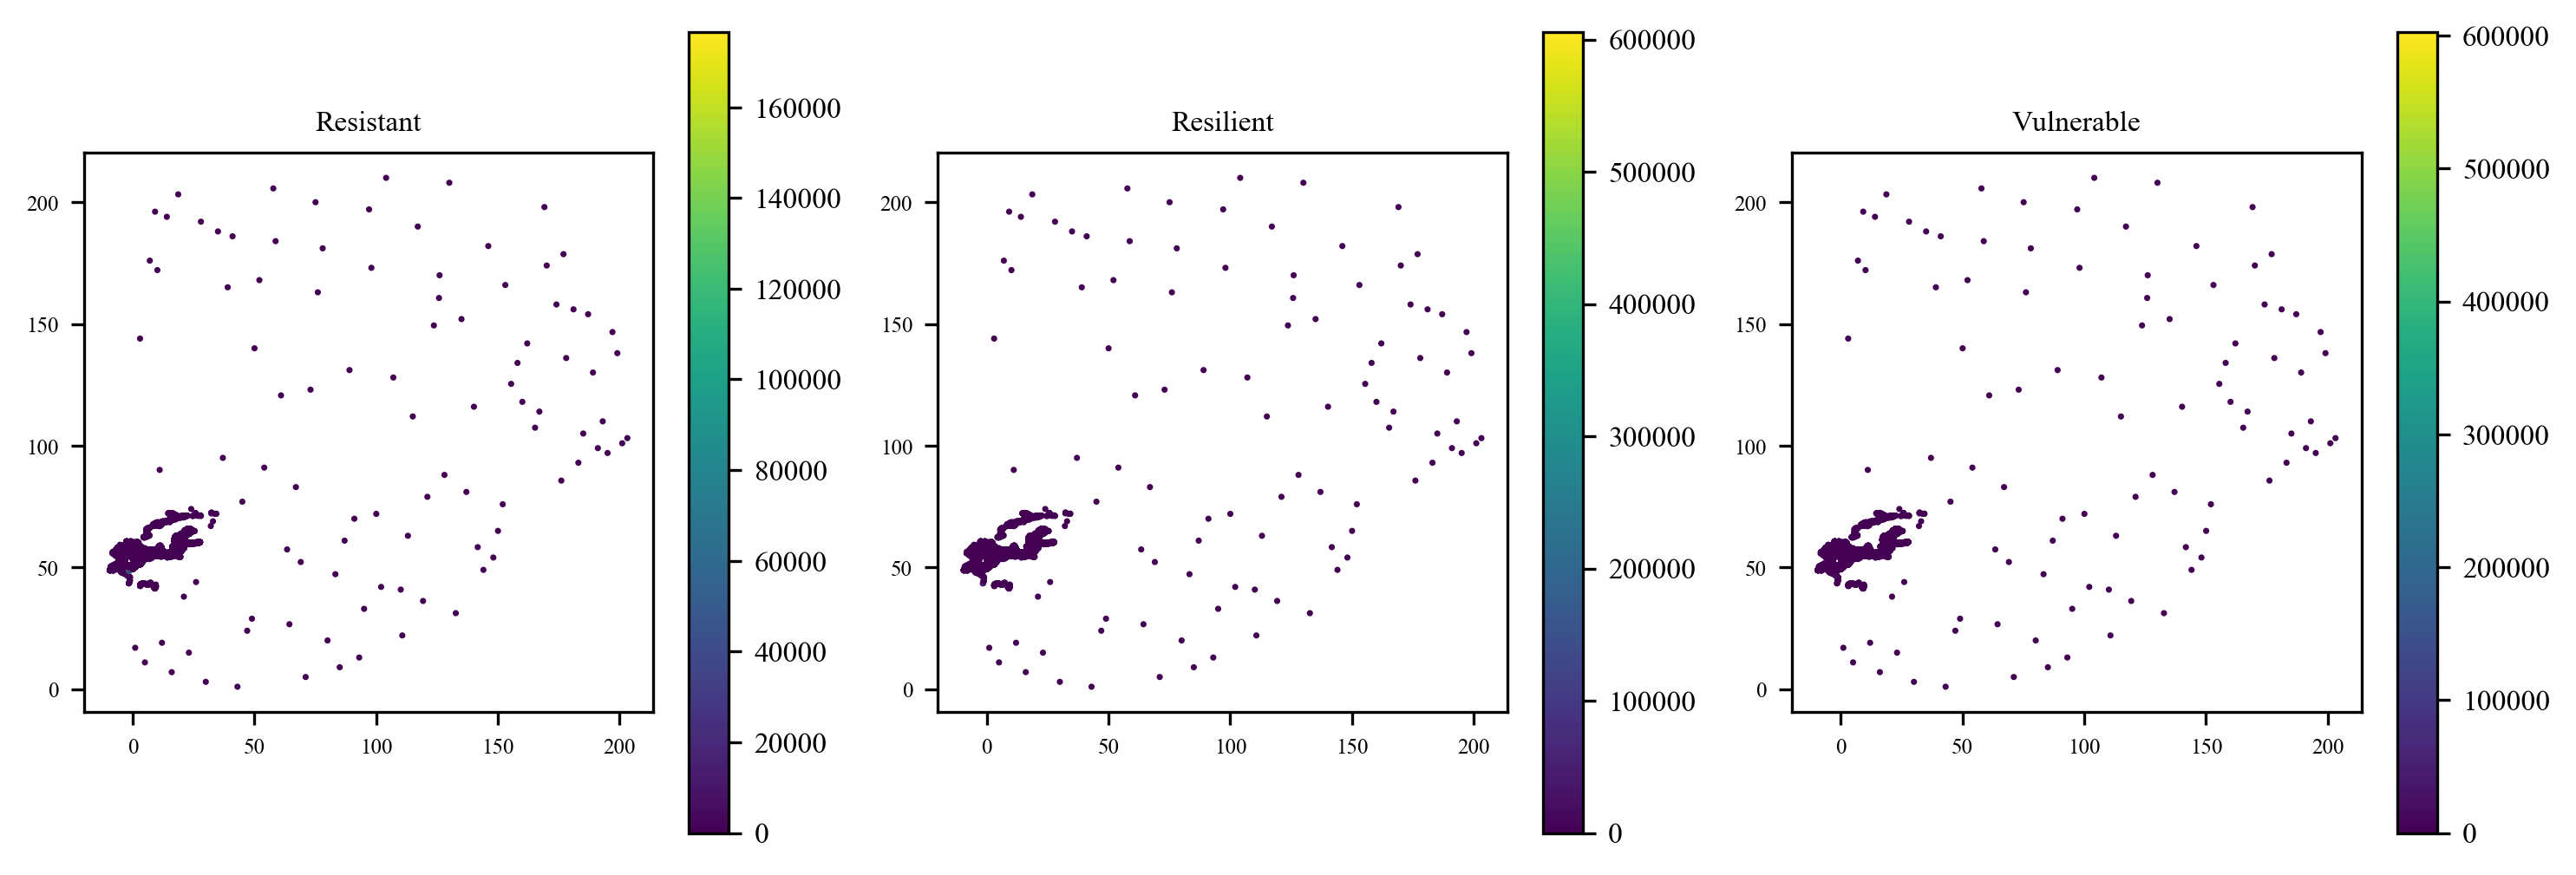

In [11]:
make_scatter_grid(g1, g2, g3)
PyPlot.savefig("Benthos_Total_densities_ab.png", dpi=300, bbox_inches="tight")

In [13]:
function make_plot_grid4(field1, field2, field3; vmin=0, vmax=1.)
    figure("benthos_results", figsize=(12,8))
    ax1 = subplot(1,3,1)
    title("Resistant", fontsize=8)
    pcm1 = pcolormesh(gridlonBenthos, gridlatBenthos, permutedims(field1, [2,1]), vmin=vmin, vmax=vmax)
    PyPlot.contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
    ax1[:tick_params]("both",labelsize=6)
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    #PyPlot.scatter(obslon, obslat, s=0.5, c=g1log, vmin=0, vmax=10.)
    cb = colorbar(pcm1, shrink=.5)[:ax][:tick_params](labelsize=8)
    ax2 = subplot(1,3,2)
    title("Resilient", fontsize=8)
    pcm2 = pcolormesh(gridlonBenthos, gridlatBenthos, permutedims(field2, [2,1]), vmin=vmin, vmax=vmax)
    PyPlot.contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
    ax2[:tick_params]("both",labelsize=6)
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    #PyPlot.scatter(obslon, obslat, s=0.5, c=g2log, vmin=0, vmax=10.)
    colorbar(pcm2, shrink=.5)[:ax][:tick_params](labelsize=8)
    ax3 = subplot(1,3,3)
    title("Vulnerable", fontsize=8)
    pcm3 = pcolormesh(gridlonBenthos, gridlatBenthos, permutedims(field3, [2,1]), vmin=vmin, vmax=vmax)
    PyPlot.contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
    ax3[:tick_params]("both",labelsize=6)
    gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
    #PyPlot.scatter(obslon, obslat, s=0.5, c=g3log, vmin=0, vmax=10.)
    colorbar(pcm3,shrink=.5)[:ax][:tick_params](labelsize=8)
end

make_plot_grid4 (generic function with 1 method)

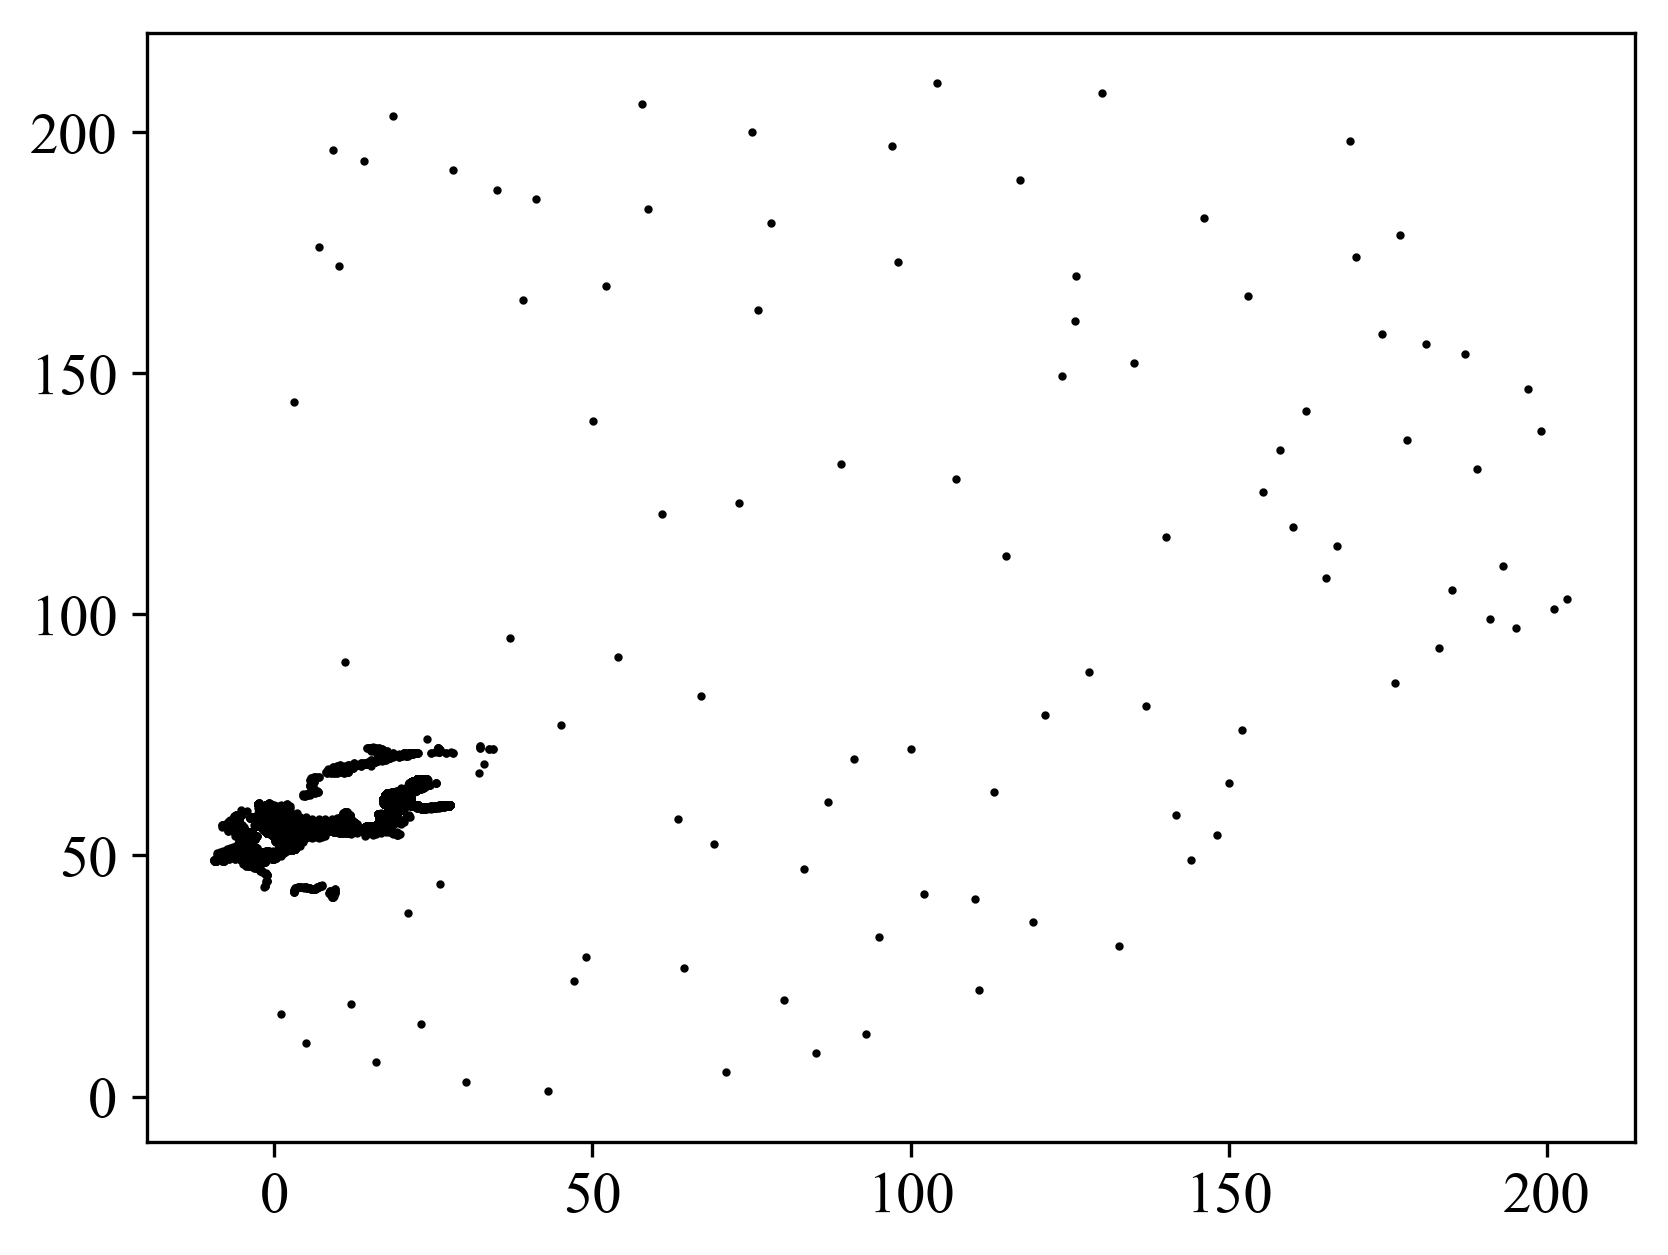

In [14]:
PyPlot.plot(obslon, obslat, "ko", markersize=1)
PyPlot.savefig("../figures/Benthos_Total_densities_ab_positions.png", dpi=300, bbox_inches="tight")

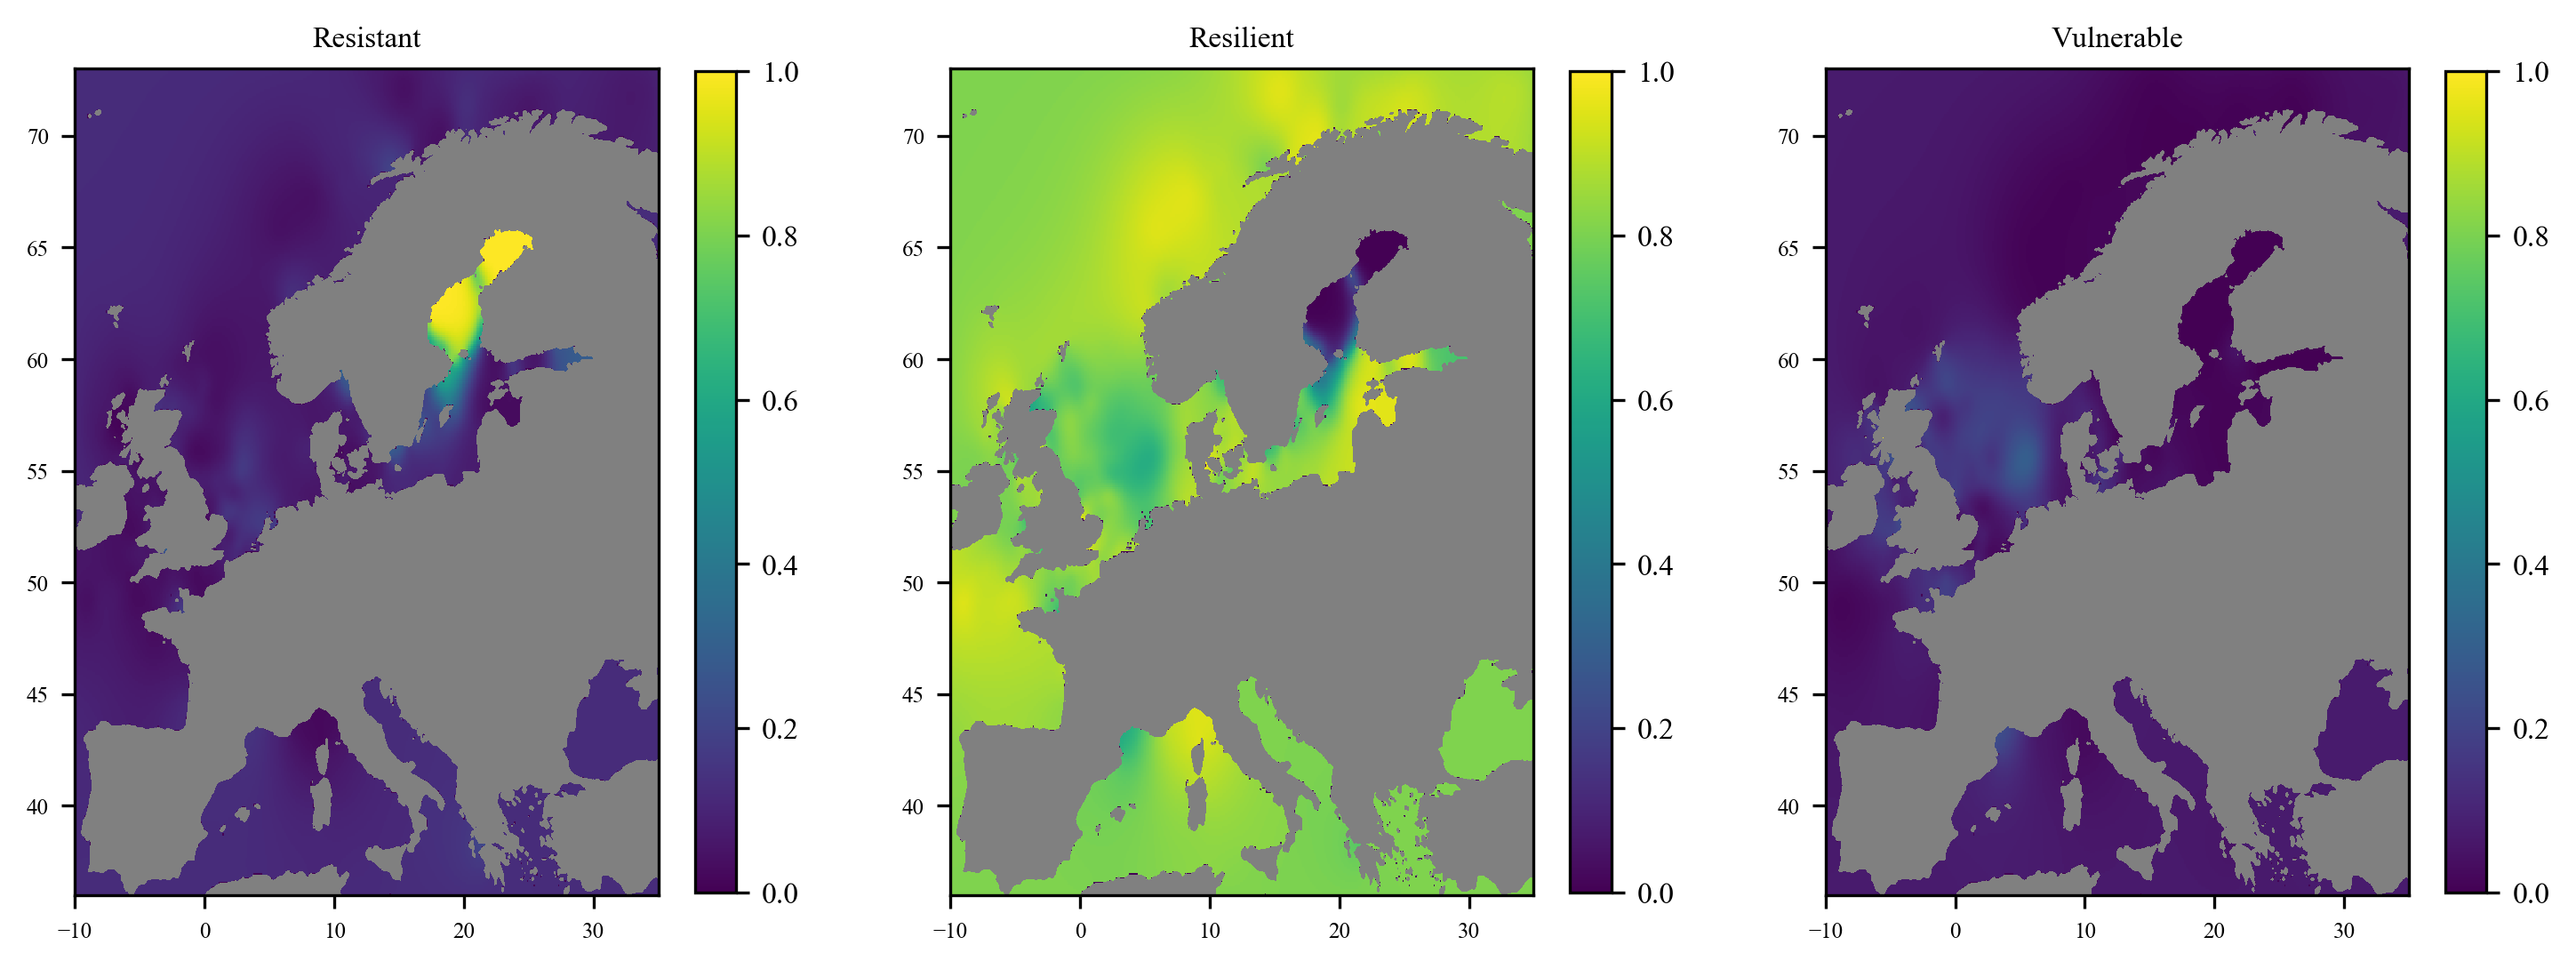

In [17]:
make_plot_grid4(fi1rel, fi2rel, fi3rel, vmin=0., vmax=1.)
PyPlot.savefig(joinpath("../figures/Benthos_Total_densities_ab.png"), dpi=300, bbox_inches="tight")

## Error field
We use the so-called *Clever Poor Man's Estimate*.

In [18]:
g1_err, g2_err, g3_err = compute_error(obslon, obslat, g1, g2, g3);

### Make plot

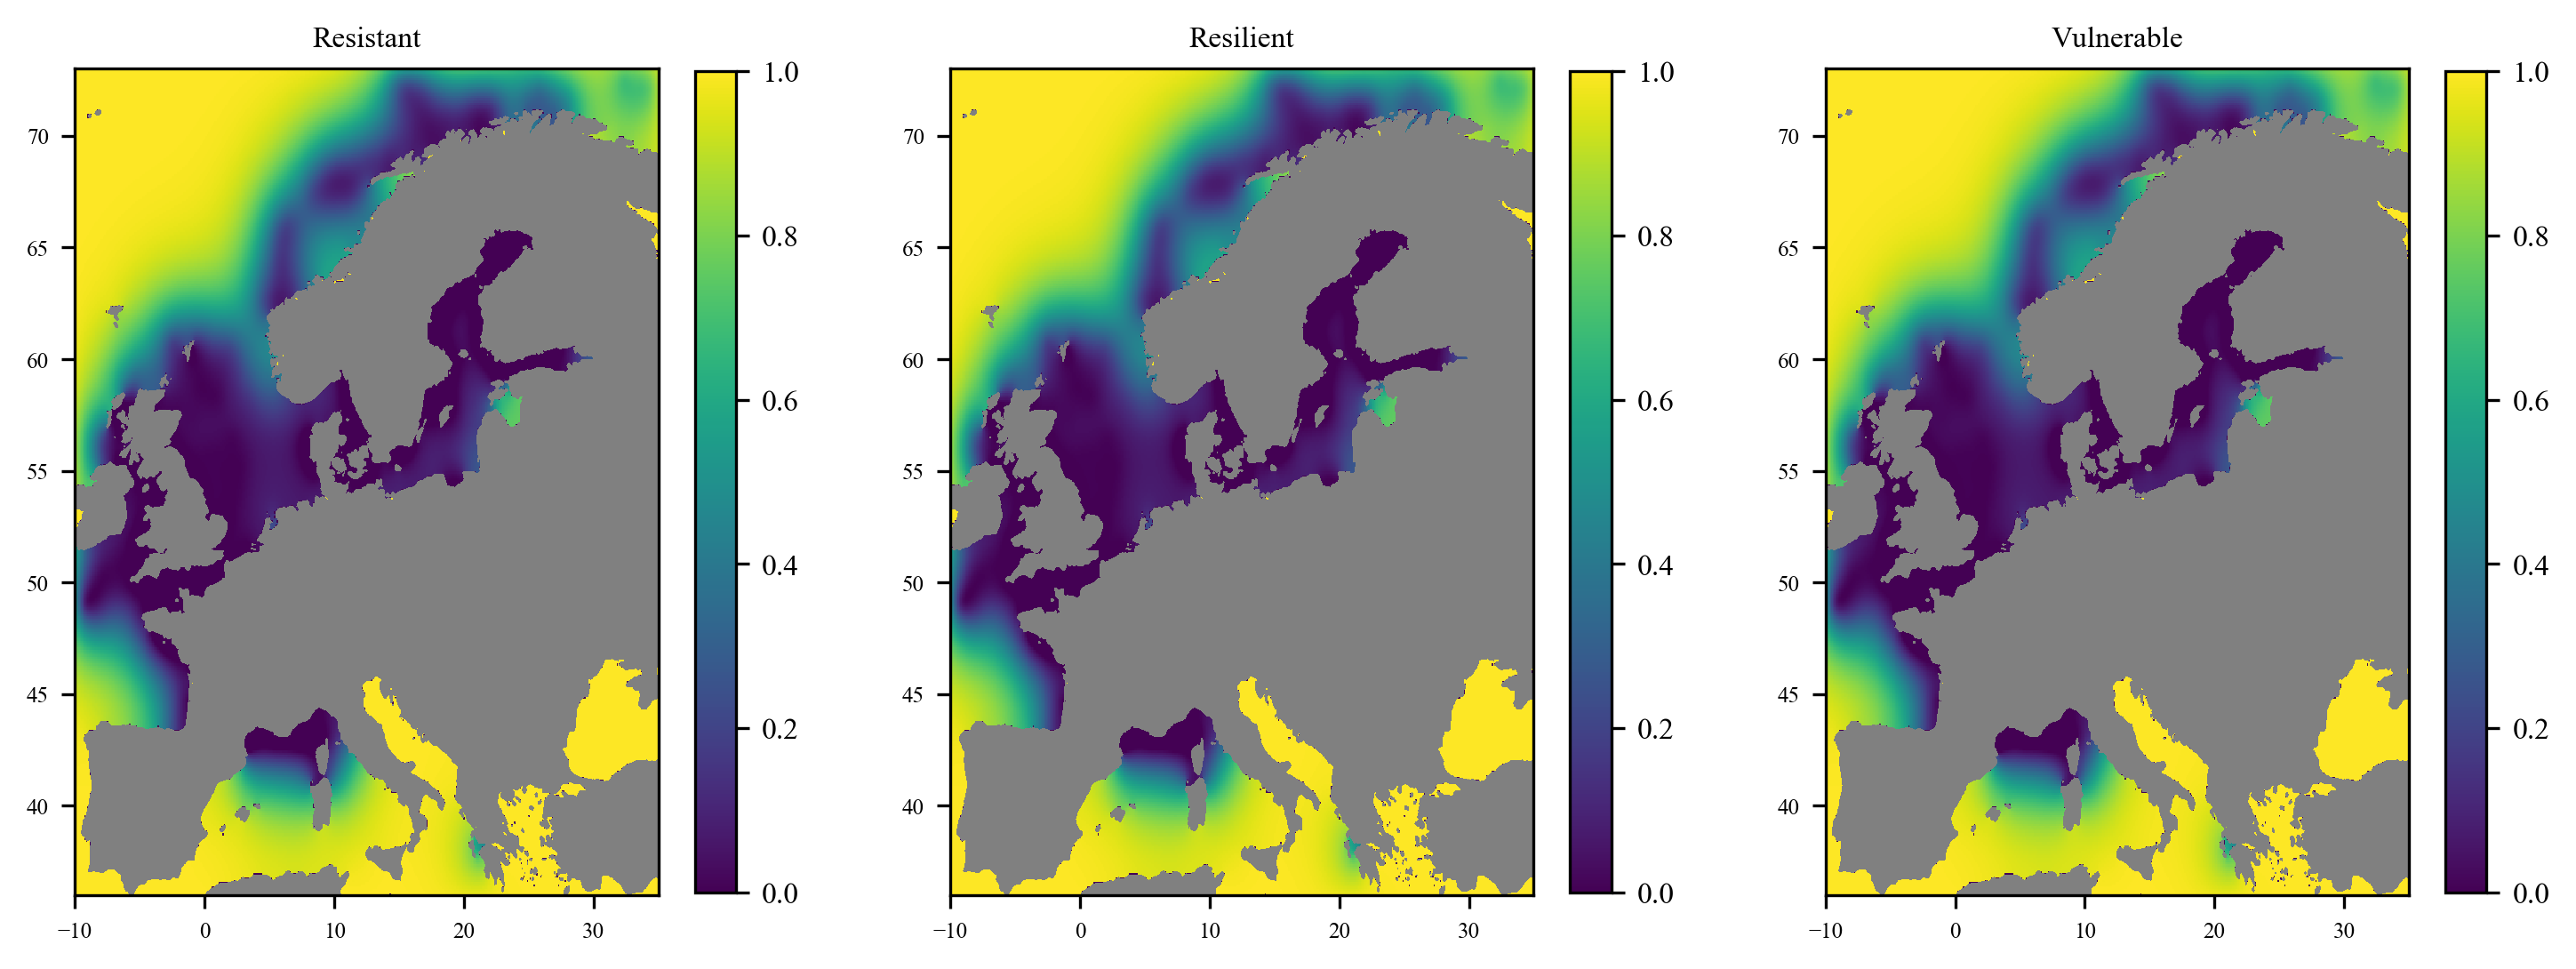

In [23]:
make_plot_grid4(g1_err, g2_err, g3_err, vmin=0, vmax=1.)
PyPlot.savefig(joinpath("../figures/Benthos_Total_densities_ab_error.png"), dpi=300, bbox_inches="tight")

## Write the results and the error field in a netCDF file
Create new output directory if necessary.

In [24]:
outputdir = "../output/"
if !isdir(outputdir)
    @info("Creating output directory $(outputdir)")
    mkdir(outputdir);
end
@info "Write netCDF"
write_benthos_nc(joinpath(outputdir, "Benthos_Total_densities_ab.nc"), gridlonBenthos, gridlatBenthos,
fi1rel, fi2rel, fi3rel, g1_err, g2_err, g3_err);

┌ Info: Write netCDF
└ @ Main In[24]:6


## Analysis of the density file
The same procedure is repeated with the density data.
### Data reading

In [25]:
fname = joinpath(datadir, "Olivier-Benthos/Benthos_Total_densities_tx.csv");
@info "Reading data file $(fname)"
obslon2, obslat2, g1b, g2b, g3b = read_benthos_abs(fname);

┌ Info: Reading data file /home/ctroupin/tmp/Emodnet-Bio/Olivier-Benthos/Benthos_Total_densities_tx.csv
└ @ Main In[25]:2


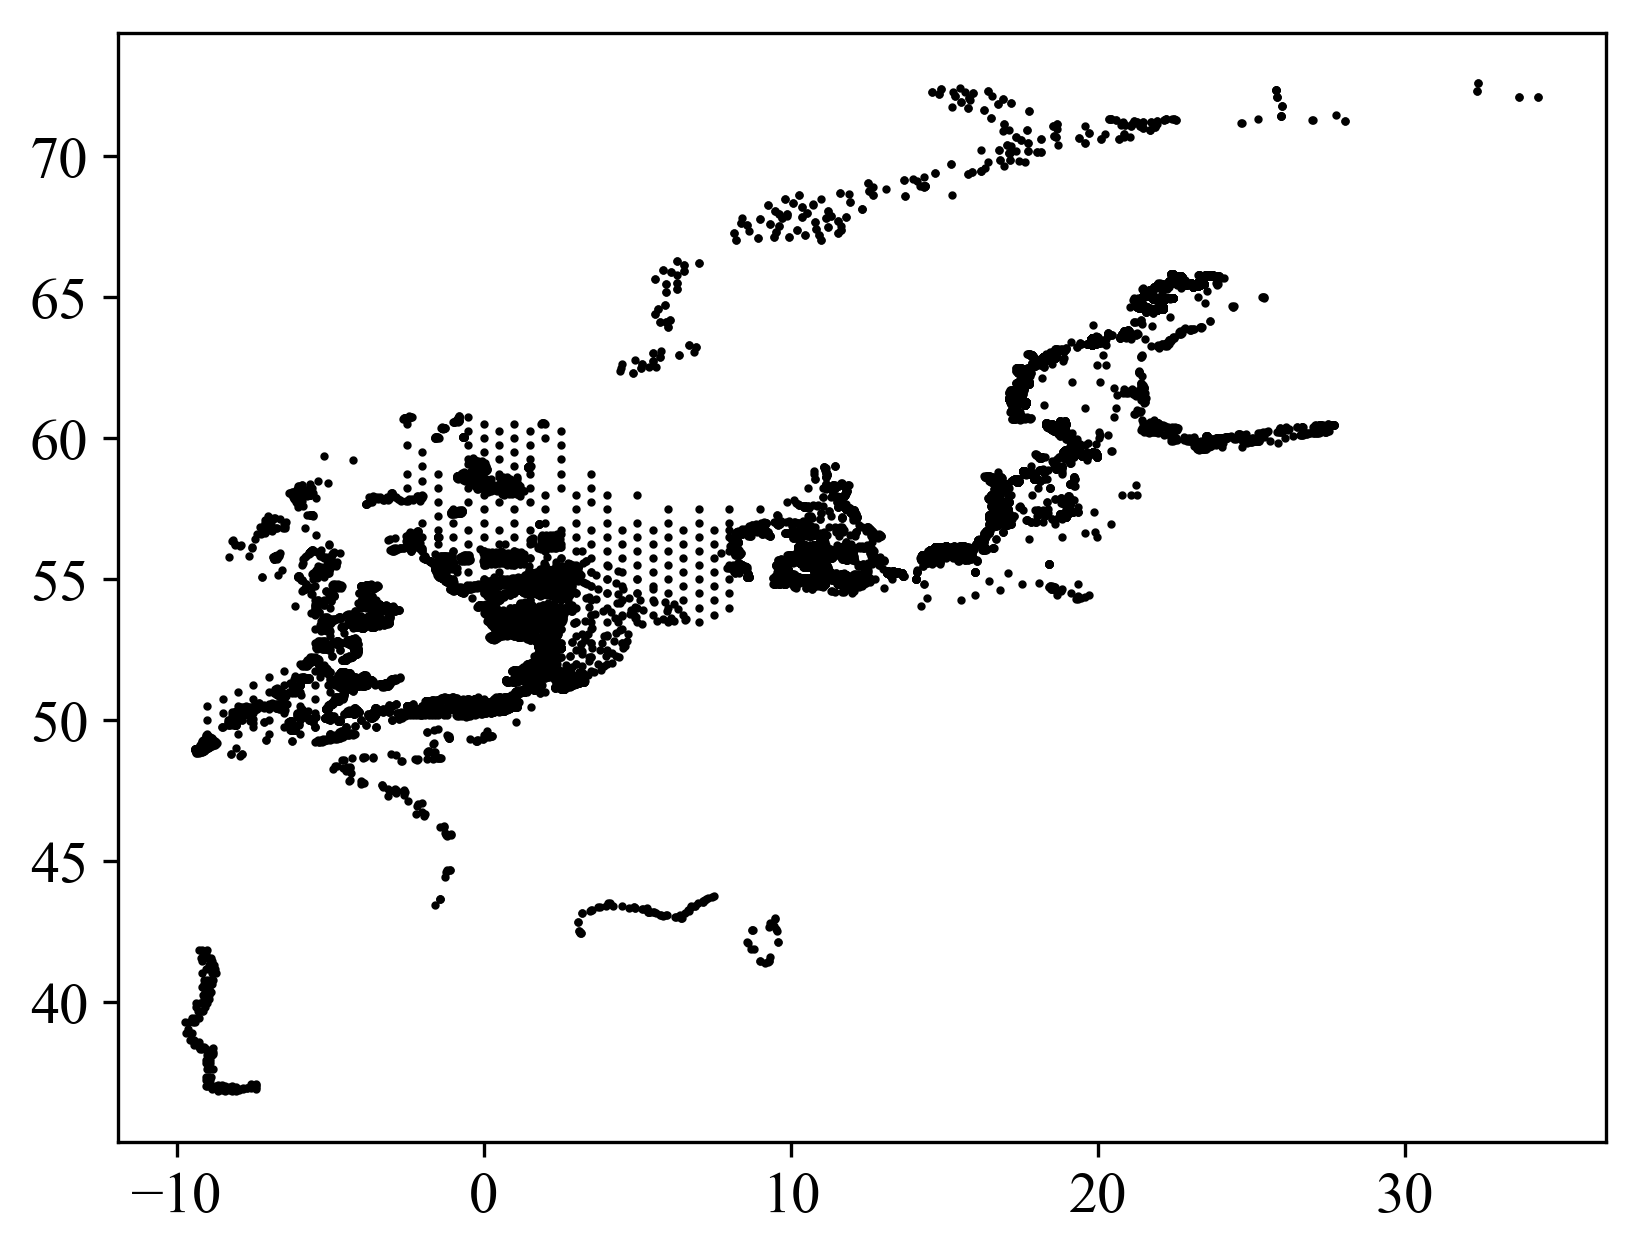

In [26]:
PyPlot.plot(obslon2, obslat2, "ko", markersize=1)
PyPlot.savefig("../figures/Benthos_Total_densities_tx_positions.png", dpi=300, bbox_inches="tight")

### Parameters
We make the analysis with the same values for the parameters.

In [27]:
# Correlation length
len = 2.;
# Observational error variance normalized by the background error variance
epsilon2 = 5.;
# Decreasing weight for close observations
rdiag=1.0./DIVAnd.weight_RtimesOne((obslon2, obslat2),(0.03,0.03))
@show maximum(rdiag),mean(rdiag);
epsilon2 = epsilon2*rdiag;

(maximum(rdiag), mean(rdiag)) = (439.4142964093766, 33.452614788527995)


In [28]:
@info "Interpolating"
f1brel, f2brel, f3brel, totalfieldb = make_analysis(obslon2, obslat2, g1b, g2b, g3b);
@info "Computing error field"
g1b_err, g2b_err, g3b_err = compute_error(obslon2, obslat2, g1b, g2b, g3b);

┌ Info: Interpolating
└ @ Main In[28]:1


  1.418939 seconds (2.30 M allocations: 1.450 GiB, 42.55% gc time)
  1.391920 seconds (2.30 M allocations: 1.450 GiB, 41.49% gc time)
  1.406629 seconds (2.30 M allocations: 1.450 GiB, 42.38% gc time)


┌ Info: Computing error field
└ @ Main In[28]:3


### Make plot
#### Analysed field

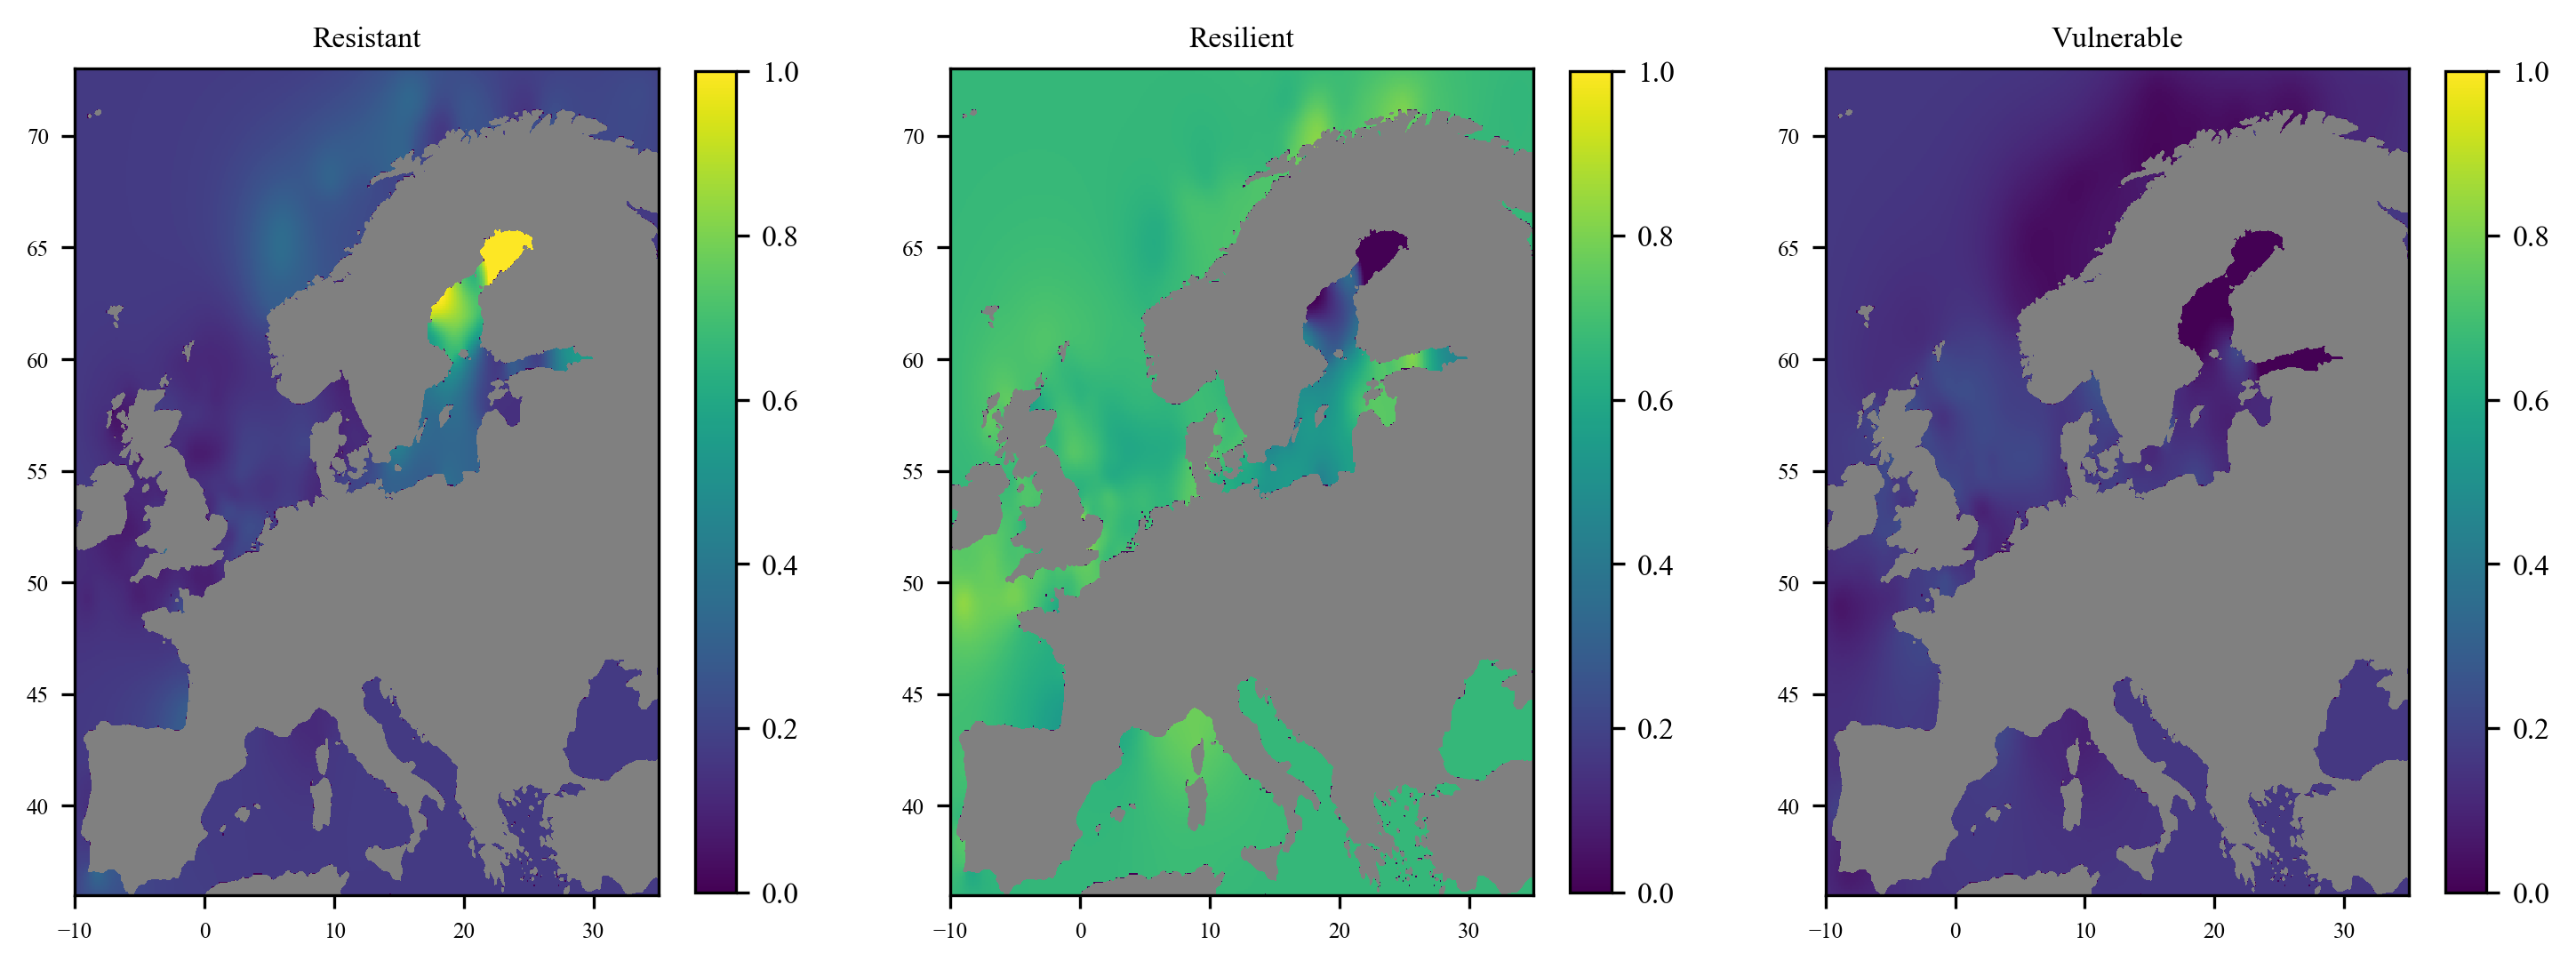

In [30]:
make_plot_grid4(f1brel, f2brel, f3brel, vmin=0., vmax=1.)
PyPlot.savefig(joinpath("../figures/Benthos_Total_densities_tx.png"), dpi=300, bbox_inches="tight")

#### Error field

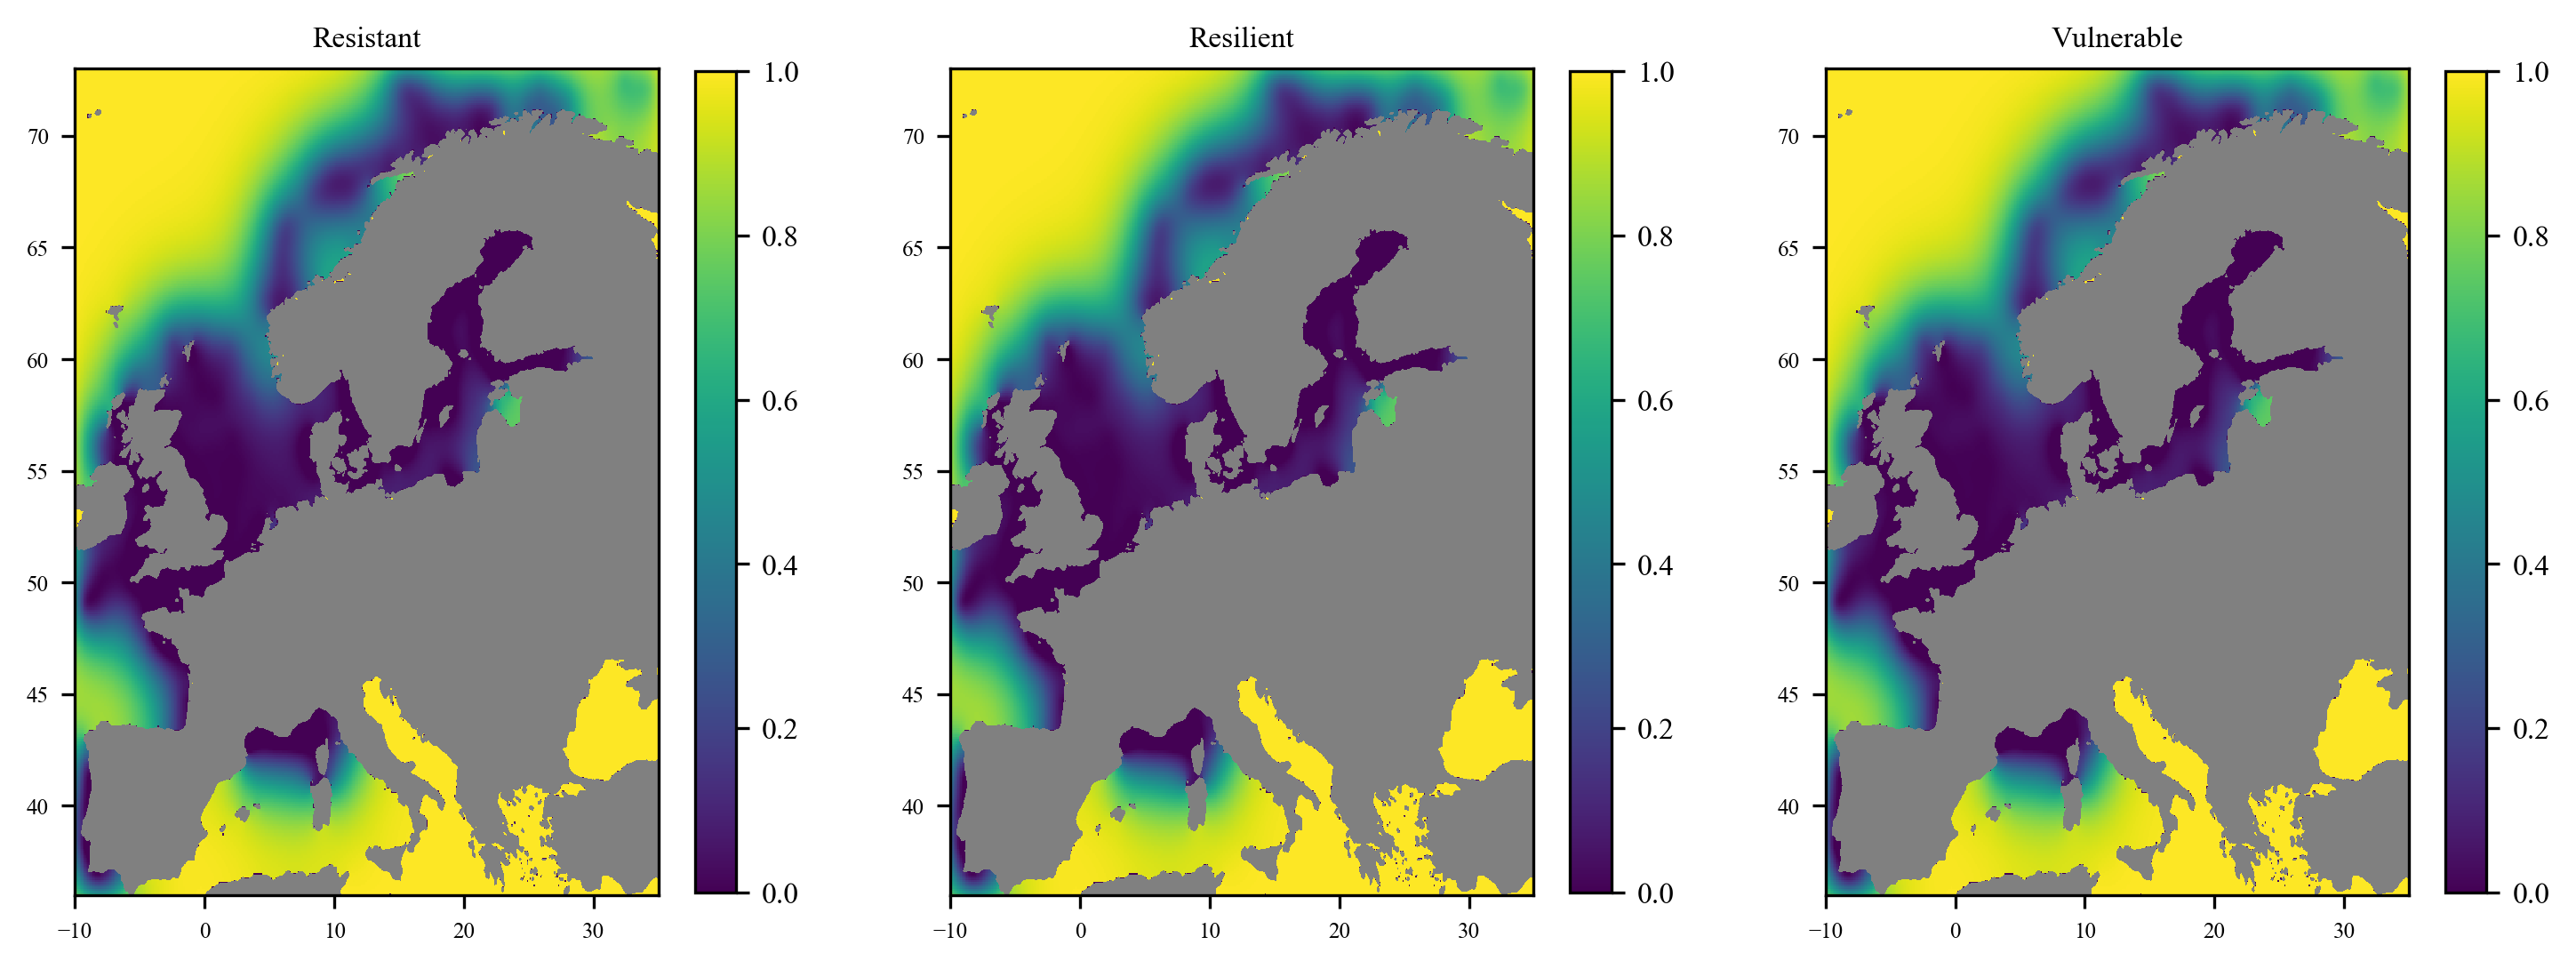

In [31]:
make_plot_grid4(g1b_err, g2b_err, g3b_err, vmin=0., vmax=1.)
PyPlot.savefig(joinpath("../figures/Benthos_Total_densities_tx_error.png"), dpi=300, bbox_inches="tight")

### Write netCDF

In [32]:
@info "Write netCDF"
write_benthos_nc(joinpath(outputdir, "Benthos_Total_densities_tx.nc"), gridlonBenthos, gridlatBenthos,
f1brel, f2brel, f3brel, g1b_err, g2b_err, g3b_err);

┌ Info: Write netCDF
└ @ Main In[32]:1
